In [1]:
import os,shutil
import tensorflow 
from tensorflow import keras
from tensorflow.keras import initializers, layers
from tensorflow.keras.layers import *
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import metrics
from pathlib import Path
import sklearn.metrics
import numpy as np
import pandas as pd
import cv2

import seaborn as sns

In [2]:
#for reproducible results
seed_value=42
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
#defining function for resizing and loading images
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(filepath,0) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [4]:
def to_rgb(img):
    
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb

In [5]:
def dataset():    
    class_=['no','yes']
    y=list()
    x=list()
    data=pd.DataFrame()
    for i,j in enumerate(class_):
        for n in os.listdir('../input/brain-tumor-detection/'+j):
            y.append(i)
            x.append('../input/brain-tumor-detection/'+j+'/'+n)

    data=pd.DataFrame(list(zip(x,y)),columns=["image","truth"])     
    return data


In [6]:
data=dataset()

In [7]:
#wavelet transform
import pywt
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
   # imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [8]:
def preprocess(data) :   
    X=np.zeros((data.shape[0],IMAGE_SIZE,IMAGE_SIZE))
    rgb_list=[]
    Y=[]
    for i in range(data.shape[0]):
        image=read_image(data['image'][i])
        if image is not None:

            X[i]=resize_image(image,(IMAGE_SIZE,IMAGE_SIZE))
            #X[i]=w2d(X[i],'db1',3)
            rgb = to_rgb(X[i])

            rgb_list.append(rgb/255.0)

            Y.append(data['truth'][i])

    rgb_arr = np.stack([rgb_list],axis=4)
    rgb_arr_to_3d = np.squeeze(rgb_arr, axis=4)
    X=rgb_arr_to_3d   
    return X, Y
        


In [9]:
X,Y= preprocess(data)

In [10]:
X.shape

(3000, 224, 224, 3)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,stratify=Y, test_size=0.1,random_state=41)

In [12]:
Y_train= to_categorical(Y_train, num_classes=2)
Y_val= to_categorical(Y_val, num_classes=2)

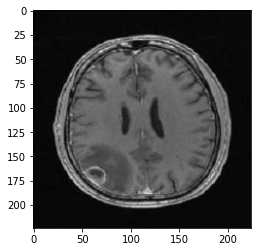

In [13]:
from  matplotlib import pyplot as plt
plt.imshow(X[0],cmap='gray')

In [14]:
###Capsule layer implementation#####3
# the squashing function.
"""
The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
:param vectors: some vectors to be squashed, N-dim tensor
:param axis: the axis to squash
:return: a Tensor with same shape as input vectors
"""
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1 #default lambda 0.5 - but test with lambda with 0.9 - 0.1
    y_pred=K.flatten(y_pred)
    y_true=K.flatten(y_true)
    return K.mean(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

def caps_batch_dot(x, y):
    x = K.expand_dims(x, 2)
    if K.int_shape(x)[3] is not None:
        y = K.permute_dimensions(y, (0, 1, 3, 2))
    o = tensorflow.matmul(x, y)
    return K.squeeze(o, 2)

class Capsule(Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            if input_shape[-2] is None:
                raise ValueError("Input Shape must be defied if weights not shared.")
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.
        This change can improve the feature representation of Capsule.
        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])

        
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].

        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(caps_batch_dot(c, hat_inputs))
            if i < self.routings - 1:
                b = caps_batch_dot(o, hat_inputs)
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)
        # End: Routing algorithm -----------------------------------------------------------------------#
        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)
        
    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(Capsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [16]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [17]:
input_shape = 224, 224, 3

input_ = Input(input_shape, name='the_input')
# wavelet = Lambda(Wavelet, name='wavelet')
wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
# print(input_l1)
# print(input_l2)
# print(input_l3)
# print(input_l4)
# level one decomposition starts
conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
norm_1 = BatchNormalization(name='norm_1')(conv_1)
relu_1 = Activation('relu', name='relu_1')(norm_1)

conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

# level two decomposition starts
conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
norm_a = BatchNormalization(name='norm_a')(conv_a)
relu_a = Activation('relu', name='relu_a')(norm_a)

# concate level one and level two decomposition
concate_level_2 = concatenate([relu_1_2, relu_a])
conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
norm_2 = BatchNormalization(name='norm_2')(conv_2)
relu_2 = Activation('relu', name='relu_2')(norm_2)

conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

# level three decomposition starts 
conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
norm_b = BatchNormalization(name='norm_b')(conv_b)
relu_b = Activation('relu', name='relu_b')(norm_b)

conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

# concate level two and level three decomposition 
concate_level_3 = concatenate([relu_2_2, relu_b_2])
conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
norm_3 = BatchNormalization(name='nomr_3')(conv_3)
relu_3 = Activation('relu', name='relu_3')(norm_3)

conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

# level four decomposition start
conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
norm_c = BatchNormalization(name='norm_c')(conv_c)
relu_c = Activation('relu', name='relu_c')(norm_c)

conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

# concate level level three and level four decomposition
concate_level_4 = concatenate([relu_3_2, relu_c_3])
conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
norm_4 = BatchNormalization(name='norm_4')(conv_4)
relu_4 = Activation('relu', name='relu_4')(norm_4)

conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)


x = Reshape((-1,128))(relu_5_1)
x = Capsule(4,16, 3, True)(x)  
x = Capsule(4, 16, 3, True)(x)
x = Capsule(4, 16, 3, True)(x)
capsule=Capsule(2,16,3,True)(x)


outputt = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)

ResCapsnet_Binarymodel = Model(input_, outputs=outputt)




2022-02-06 09:49:16.710518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 09:49:16.806576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 09:49:16.807346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 09:49:16.808566: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
ResCapsnet_Binarymodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
wavelet (Lambda)                [(None, 112, 112, 12 0           the_input[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 112, 112, 64) 6976        wavelet[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 112, 112, 64) 256         conv_1[0][0]                     
______________________________________________________________________________________________

In [19]:
X_val.shape

(300, 224, 224, 3)

In [20]:
X_train.shape

(2700, 224, 224, 3)

In [21]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          16009        8577        3594           8        3837        7148
Swap:             0           0           0


In [22]:
del X, Y

In [23]:
import gc
gc.collect()

11222

In [24]:
opt= Adam()
ResCapsnet_Binarymodel.compile(
    optimizer=opt,
    loss=margin_loss,
    metrics=['accuracy'],
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



es =  ModelCheckpoint(monitor='val_accuracy', mode='max', filepath='./model.h5',save_weights_only=True,save_best_only=True  )
es1 =  ModelCheckpoint(monitor='val_loss', mode='min', filepath='./model_loss.h5',save_weights_only=True,save_best_only=True  )

history=ResCapsnet_Binarymodel.fit(X_train,Y_train ,epochs=20,validation_split=0.10, batch_size=32, callbacks=[es,es1])

2022-02-06 09:49:21.297331: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1463132160 exceeds 10% of free system memory.
2022-02-06 09:49:22.873932: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1463132160 exceeds 10% of free system memory.
2022-02-06 09:49:23.943381: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-06 09:49:29.979146: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


76/76 [==============================] - 20s 104ms/step - loss: 0.1627 - accuracy: 0.6066 - val_loss: 0.1238 - val_accuracy: 0.4963
Epoch 2/20
76/76 [==============================] - 6s 74ms/step - loss: 0.0683 - accuracy: 0.8000 - val_loss: 0.3244 - val_accuracy: 0.4963
Epoch 3/20
76/76 [==============================] - 6s 73ms/step - loss: 0.0556 - accuracy: 0.8235 - val_loss: 0.0842 - val_accuracy: 0.7852
Epoch 4/20
76/76 [==============================] - 6s 74ms/step - loss: 0.0335 - accuracy: 0.9008 - val_loss: 0.1460 - val_accuracy: 0.6148
Epoch 5/20
76/76 [==============================] - 6s 73ms/step - loss: 0.0345 - accuracy: 0.8984 - val_loss: 0.1000 - val_accuracy: 0.6889
Epoch 6/20
76/76 [==============================] - 6s 75ms/step - loss: 0.0280 - accuracy: 0.9226 - val_loss: 0.0547 - val_accuracy: 0.8222
Epoch 7/20
76/76 [==============================] - 6s 73ms/step - loss: 0.0200 - accuracy: 0.9436 - val_loss: 0.0284 - val_accuracy: 0.9185
Epoch 8/20
76/76 [====

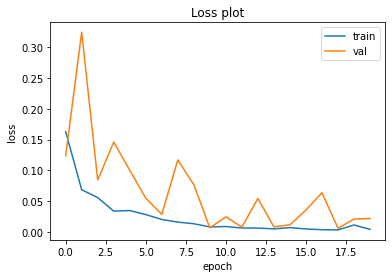

In [25]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



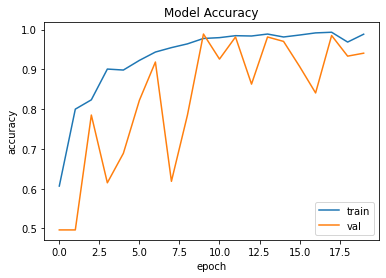

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [34]:
ResCapsnet_Binarymodel.load_weights('./model_loss.h5')
pred = ResCapsnet_Binarymodel.predict(X_val)
ResCapsnet_Binarymodel.evaluate(X_val,Y_val)

10/10 [==============================] - 0s 27ms/step - loss: 0.0074 - accuracy: 0.9867


[0.00736577995121479, 0.9866666793823242]

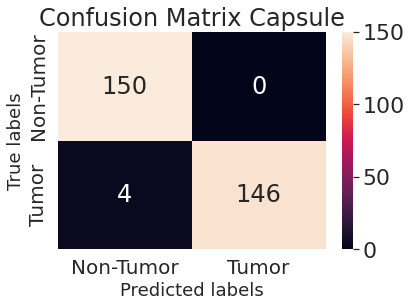

In [35]:
confusion_matrix=sklearn.metrics.confusion_matrix(Y_val.argmax(axis=1), ResCapsnet_Binarymodel.predict(X_val).argmax(axis=1))
ax= plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels',fontdict={'size':'18'});ax.set_ylabel('True labels',fontdict={'size':'18'}); 
ax.set_title('Confusion Matrix Capsule',fontdict={'size':'24'}); 
ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Non-Tumor', 'Tumor']); ax.yaxis.set_ticklabels(['Non-Tumor', 'Tumor']);

In [36]:
from sklearn.metrics import classification_report
print(classification_report(Y_val.argmax(axis=1), pred.argmax(axis=1), target_names=['Non-Tumor', 'Tumor']))

              precision    recall  f1-score   support

   Non-Tumor       0.97      1.00      0.99       150
       Tumor       1.00      0.97      0.99       150

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

